In [2]:
import numpy as np
import networkx as nx
import geopandas as gpd
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
import itertools
from collections import defaultdict

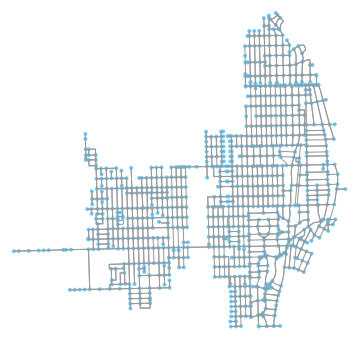

In [3]:
cw = gpd.read_file('497_Data/Wards/chiwards.shp')
cw = cw[pd.notnull(cw['geometry'])]
ward_19 = cw[(cw['ward']=='19')]
polygon = ward_19['geometry'].iloc[0]
gdf = ox.graph_from_polygon(polygon, network_type='drive', simplify=True)
gdf = max(nx.strongly_connected_component_subgraphs(gdf), key=len)
gdf_projected = ox.project_graph(gdf)
fig, ax = ox.plot_graph(gdf)

In [5]:
V1 = [261169915, 261223456, 261213381, 261199228, 261131851, 261166194, 261166193, 261166192, 261166191, 261169916, 261213382, 261199229, 261131848, 261302351, 261213383, 261199230, 261131847, 5125969371] 

In [70]:
# Initializing graph
G1 = nx.MultiDiGraph() 
mdict_length = {} 
mdict_path = {}
for v in V1:
    mdict_length[v] = nx.shortest_path_length(gdf, v, weight='length')
    mdict_path[v] = nx.shortest_path(gdf, v, weight='length')
    for u in V1:
        if u!=v:
            G1.add_edge(v,u,distance=mdict_length[v][u], path=mdict_path[v][u])

#creating distance matrix: 
distance_matrix = nx.to_numpy_matrix(G1, nodelist=V1, weight='distance')
distance_matrix #create the distance matrix

#making the matrix symmetric: 
symmetric_matrix = np.maximum(distance_matrix, distance_matrix.transpose())

#turn the distance matrix back into a graph

G1_symmetric=nx.from_numpy_matrix(symmetric_matrix)



T=nx.minimum_spanning_tree(G1_symmetric)



odd_vert = []
for n in T.nodes(): 
    if(T.degree(n) %2 !=0): 
        odd_vert.append(n)
        
G1_ss = G1_symmetric.subgraph(odd_vert).copy()

 
min_matched = nx.max_weight_matching(G1_ss, maxcardinality=True)

mate = {}
for s in min_matched: 
    mate[s[0]] = s[1]
    
for u,v in mate.items(): 
    T.add_edge(u, v, weight=G1_ss[u][v]['weight'])
 

e_circuit = [v for v in nx.eulerian_circuit(T, source=0)]
h_cycle = [v for idx,v in enumerate(e_circuit) if v not in e_circuit[:idx]] 
print(h_cycle)
pothole_circuit = []
pothole_circuit_length = 0
for idx in range(0,len(h_cycle)):
    u,v = V1[h_cycle[idx][0]], V1[h_cycle[idx][1]]
    
    if(idx==(len(h_cycle)-1)): 
        path = (G1[u][v][0]['path'])
    else: 
        path = (G1[u][v][0]['path'])[:-1]
    pothole_circuit += path
    pothole_circuit_length += G1[u][v][0]['distance']


[(0, 5), (5, 10), (10, 11), (11, 9), (9, 5), (5, 6), (6, 7), (7, 8), (8, 11), (11, 12), (12, 16), (16, 17), (17, 15), (15, 14), (14, 13), (13, 4), (4, 3), (3, 2), (2, 1), (1, 0)]


In [71]:
edges = [tuple((pothole_circuit[i], pothole_circuit[i+1])) for i in range(0, len(pothole_circuit)-1)]

In [72]:
gdf_sub = gdf.subgraph(pothole_circuit)
node_positions = {node[0]: (node[1]['x'], node[1]['y']) for node in gdf_sub.nodes(data=True)}
node_positions

{261199228: (-87.7024993, 41.704332),
 261286430: (-87.7048776, 41.7015676),
 261286432: (-87.7049853, 41.701566),
 261223456: (-87.7049758, 41.7042959),
 261213381: (-87.7037235, 41.7043141),
 261213382: (-87.7036212, 41.7015852),
 261131847: (-87.701148, 41.7006943),
 261131848: (-87.7011803, 41.7016196),
 261213383: (-87.7035834, 41.7005821),
 261131849: (-87.7012119, 41.7025262),
 5274567753: (-87.7012121, 41.7025327),
 261131851: (-87.7012755, 41.7043498),
 261302351: (-87.7049483, 41.7005637),
 5125969371: (-87.7011452, 41.7006149),
 261166191: (-87.7024352, 41.7025126),
 261166192: (-87.7036552, 41.702499),
 261166193: (-87.7049121, 41.702485),
 261166194: (-87.7061055, 41.7024717),
 261169915: (-87.7061906, 41.7042782),
 261169916: (-87.7060618, 41.7015509),
 261199229: (-87.7023974, 41.7016024),
 261199230: (-87.7023445, 41.7005987)}

In [67]:
import itertools
import copy

gdf_sub = gdf.subgraph(pothole_circuit)
node_positions = {node[0]: (node[1]['x'], node[1]['y']) for node in gdf_sub.nodes(data=True)}
node_positions

for i, e in enumerate(pothole_circuit):
    euler_circuit_i = copy.deepcopy(edges[0:i])
    
    g_i = nx.Graph(euler_circuit_i)
    #print(g_i.edges())
    # Full graph (faded in background)
    plt.figure(figsize=(14, 10))
    plt.axis('off')
    nx.draw_networkx(gdf_sub, pos=node_positions, node_size=6, node_color='gray', with_labels=False, alpha=0.07)

    # Edges walked as of iteration i
    

    nx.draw_networkx_nodes(g_i, pos=node_positions, node_size=6, alpha=0.6, node_color='lightgray', with_labels=True, linewidths=0.1)
    nx.draw_networkx_edges(g_i, pos=node_positions, alpha=0.8, width=2.0, edge_color='g')

    plt.axis('off')
    plt.savefig('fig/png/img{}.png'.format(i), dpi=120, bbox_inches='tight')
    plt.close()

In [68]:
import glob
import numpy as np
import imageio
import os

def make_circuit_video(image_path, movie_filename, fps=5):
    # sorting filenames in order
    filenames = glob.glob(image_path + 'img*.png')
    filenames_sort_indices = np.argsort([int(os.path.basename(filename).split('.')[0][3:]) for filename in filenames])
    filenames = [filenames[i] for i in filenames_sort_indices]

    # make movie
    with imageio.get_writer(movie_filename, mode='I', fps=fps) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

make_circuit_video('fig/png/', 'fig/gif/tsp_route_animation.gif', fps=2)